###### author Leonardo Machado Antonio RA 024308

# Low order finite elements methods using Garlekin residual weights

The following code intents to solve the differential equation:

$ \displaystyle \frac{d^2 u(x)}{dx^2} + u(x) = (2-4x)\displaystyle e^x$

with low order isoparametric Garlekin residual weights.

The boundary conditions of the problem are:

$u(0) = 0$

$u(2) = 0$

The domain is: 

$\Omega = \displaystyle\left\{x \in \mathbb{R} | \quad 0 \leq x \leq 2 \right\}$

## Code pre processing module

The user may set the number of elements that will compose the domain partition, assigned by the variable $NEL$, and order for Lagragian basis functions, where 2 means linear and 3 quadratic.

In [37]:
%matplotlib inline
import numpy
import math
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

#number of elements
NEL = 20
#flag for basis Lagrange functions, where: (2) means linear and (3) quadratic
NLG = 3

### Function used for this computational implemention

There are two routines implemented for this code. The first, corresponds the the right hand side (RHS), where the term $(2-4x)e^x$ is calculated to an assigned value of $x$. The second is related Gauss quadrature points for numerical integration.

In [38]:
def x2F(xpt):
    """Returns the RHS function calculation at xpt.
    
    Parameters
    ----------
    xpt : point on the x domain for function calculation
    
    Returns
    -------
    FX : Function calculated at xpt 
    
    """
    Fx = (2-4*xpt)*numpy.exp(xpt);
            
    return Fx

def GaussQ(NLG):
    """Returns quadrature points and weights for Gauss numerical integration based
    on the chosen Lagrange basis function.
    
    Parameters
    ----------
    NLG : flag for Lagrange basis function indication.
    
        (2) linear
        (3) quadratic    
    
    Returns
    -------
    GaussPts: Quadrature points for Gauss numerical integration
    GaussWgt: Quadrature weights for Gauss numerical integration
    
    """
    
    if NLG == 2:
        GaussPts = [-math.sqrt(3.0)/3.0, math.sqrt(3.0)/3.0]
        GaussWgt = [1.0, 1.0]
        
    elif NLG ==3:
        GaussPts = [-math.sqrt(3.0/5.0), 0.0 , math.sqrt(3.0/5.0)]
        GaussWgt = [5.0/9.0, 8.0/9.0, 5.0/9.0]
           
    return [GaussPts,GaussWgt]

### Inicidence, Coordinate and Boundary Matrix assembly

The finite element is isoparametric, thus the number of nodes that composes each element is equivalent to the order. The linear elements has two nodes and quadratic, three, what will be set by the user by $NLG$ variable. 

The incidence matrix assembly is directly dependent of NGL, once each line corresponds to a element and column to elements node.

The coordinate matrix is related to the domain partition, the nodes. Each line corresponds to a node coordinate. Its first column is the node number and the second the x coordinate. 

The boundary condition are grouped in a matrix, where each line corresponds to an input and the columns are divided in: 

1. node affected
2. Degree of freedom affected. (obs.: for this code only one degree of freedom is considered)
3. value assigned to the degree. (obs.: valeus different from zero are not considered in this code implementation)


In [39]:
#incidence Matrix Assembly
aux = 0  
inciMat = numpy.zeros((NEL,NLG))
for i in range(0,NEL):
    aux = aux - 1    
    for j in range (0,NLG):
        aux = aux+1        
        inciMat[i,j] = aux

#Coordinate Matrix Assembly
x = numpy.linspace(0.0,2.0,aux+1)
coorMat = numpy.zeros((len(x),2))
for i in range (0,len(x)):
    coorMat[i,0] = i
    coorMat[i,1] = x[i]    
    lastnode = i

#Boundary condition Matrix Assembly
bdryMat = numpy.zeros((2,3))
bdryMat[0,:] = [0, 0, 0]
bdryMat[1,:] = [lastnode, 0, 0]

## Code processing module

The processing module is composed by two main stages: global stiffness matrix and load vector assembly and linear system solver. 
Initially the equation identification matrix is assigned, where each line is related to a element node and the column to degree of freedom. Once, there is only one degree of freedom for this problem, the id Matrix will be equivalent to a vector. This matrix assigns identification number to a variable and will be useful for global matrix and vector assembly 

The boundary condition assigns the value $-1$ for the related node and, for the global stiffness matrix, all entries related to the line and column will be assigned the value $0$ and $1$ for the diagonal term. The global load vector, for the correspondence to the boundary condition assignment, the value will be forced to be $0$ (observation: this code takes in cosideration only zero values for boundary condition, although the implementation of different values demands only a modification on global load vector). This approach is defined as zero-one treatement according to COOK, MALKUS e PLESHA3 (1993)

The finite element is isoparametric, what will imply, for quadratic basis function, that the Jacobian determinant is depend of $\xi$ (affine mapping coordinate), as shown below:

$[J]= \left[\begin{array}{lll} \dfrac{\partial\phi_1}{\partial \xi} \dfrac{\partial\phi_2}{\partial \xi} \dfrac{\partial\phi_3}{\partial \xi}\end{array}\right] \left[\begin{array}{l} x_1 \\ x_2 \\ x_3 \end{array}\right] \quad \Rightarrow \quad det[J] = x_1\left(\xi -\dfrac{1}{2}\right)-2\xi x_2 + x_3\left(\xi + \dfrac{1}{2}\right)$




In [40]:
#id Matrix assembly
idMat = numpy.zeros((lastnode+1,1))
NEQ = -1
for i in range(0,lastnode+1):
    if idMat[i,0] == 1:
        idMat[i,0] = -1
    else:
        NEQ = NEQ+1
        idMat[i,0] = NEQ
for i in range(0,2):
    idMat[int(bdryMat[i,0]),int(bdryMat[i,1])] = -1

#Basis function calculation at Gauss integrations points
[GaussPts,GaussWgt] = GaussQ(NLG)
phi = numpy.zeros((NLG,NLG))
dphi = numpy.zeros_like(phi)
if NLG == 2:
    for i in range (0,NLG):
        phi[i,:] = [0.5*(1-GaussPts[i]), 0.5*(1+GaussPts[i])]
        dphi[i,:] =[-0.5, 0.5]
elif NLG ==3:
    for i in range (0,NLG):
        phi[i,:] = [0.5*(1-GaussPts[i]), 0.5*(1+GaussPts[i]), 0]
        phi[i,2] = phi[i,1]
        phi[i,1] = 4*phi[i,0]*phi[i,2]
        phi[i,0] = phi[i,0]*(2*phi[i,0]-1)
        phi[i,2] = phi[i,2]*(2*phi[i,2]-1)
        dphi[i,:] = [GaussPts[i]-0.5, -2*GaussPts[i], GaussPts[i]+0.5]

#stiffness matrix and load vector assembly
kMat = numpy.zeros((lastnode+1,lastnode+1))
qVec = numpy.zeros((lastnode+1,1))
node = numpy.zeros((NLG,1))
loc = numpy.zeros((NLG,1))

for i in range(0,NEL): #element loop    
        
    for j in range(0,NLG):        
        node[j] = coorMat[int(inciMat[i,j]),1]    
        loc[j] = idMat[int(inciMat[i,j]),0]  

    #element load vector calculation
    qeVec = numpy.zeros((NLG,1))
    #element mass and stiffness matrix calculation
    meMat = numpy.zeros((NLG,NLG))
    keMat = numpy.zeros((NLG,NLG))
    
    for j in range(0,NLG): 
        detJ = 0
        xpt = 0
        for k in range (0,NLG): 
            detJ = detJ + node[k]*dphi[j,k]
            xpt = xpt + node[k]*phi[j,k]
            
        for k in range (0,NLG):
            #load vector loop
            qeVec[k,0] = qeVec[k,0] + GaussWgt[j]*x2F(xpt)*detJ*phi[j,k]
            
            for l in range (0,NLG):
                #mass and stiffness matrix loop
                keMat[k,l] = keMat[k,l] + (GaussWgt[j]/detJ)*dphi[j,k]*dphi[j,l]
                meMat[k,l] = meMat[k,l] + (GaussWgt[j]*detJ)*phi[j,k]*phi[j,l]
 
    #global load vector assembly            
    for j in range (0,NLG): #assembly loop
        if int(loc[j]) != -1:
            qVec[int(loc[j]),0] = qVec[int(loc[j]),0] + qeVec[j,0]            
            for k in range (0,NLG):
                if loc[k] != -1:
                    kMat[int(loc[j]),int(loc[k])] = kMat[int(loc[j]),int(loc[k])] + keMat[j,k] + meMat[j,k]
               
#zero-one treatment for boundary conditions application
for i in range(0,2):
    kMat[int(bdryMat[i,0]),int(bdryMat[i,0])] = 1    
    
#linear system solver
u = numpy.linalg.solve(kMat, qVec)

## Code post processing

For comparison, the numeric results are compared with the analytic solution of the differential equation, as shown below: 

$u(x) = x(x-2) e^x$

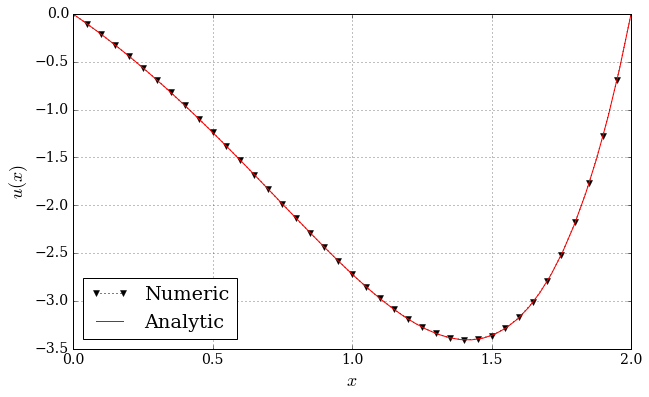

In [41]:
#analytical solution for comparison
xan = numpy.linspace(0.0,2.0,50)
uan = numpy.zeros((len(xan),1))

for i in range(0,len(xan)):
    uan[i,0] = xan[i]*(xan[i]-2)*numpy.exp(xan[i])

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.tick_params(axis='both', labelsize=14)
pyplot.plot(coorMat[:,1], u, 'kv:', label='Numeric')
pyplot.plot(xan, uan, 'r-', label='Analytic') 
pyplot.xlabel('$x$', fontsize=18)
pyplot.ylabel('$u(x)$', fontsize=18)
pyplot.legend(loc='lower left');     

For result quality evaluation, the error plot is shown below. The error is calculated by:

$error = u(x)_{analytic}-u(x)_{numeric}$

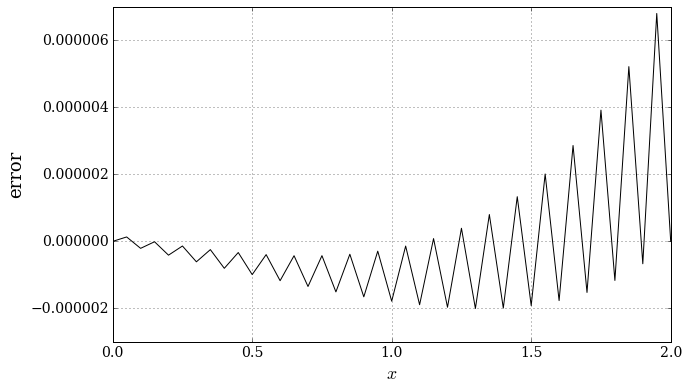

In [42]:
uan2error = numpy.zeros((len(x),1))
error = numpy.zeros_like(uan2error)
for i in range(0,len(x)):
    uan2error[i,0] = coorMat[i,1]*(coorMat[i,1]-2)*numpy.exp(coorMat[i,1])
    error[i] = (uan2error[i,0]-u[i,0])#/uan2error[i,0]

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.tick_params(axis='both', labelsize=14)
pyplot.plot(coorMat[:,1], error, 'k')
pyplot.xlabel('$x$', fontsize=18)
pyplot.ylabel('error', fontsize=18)


### References

COOK, R.; MALKUS, D.; PLESHA, M. CONCEPTS AND APPLICATIONS OF FINITE ELEMENT ANALYSIS. New York: John wiley & Sons, 1993.